# <center> Lecture15 : 课程回顾和复习 </center>  
 
## <center> Instructor: Dr. Hu Chuan-Peng </center> 

## Outlines

| 序号  |                    课程内容                     |
| :--: | :--------------------------------------------: |
|  1   |                    课程介绍                     |  
|  2   |                  Bayes' Rule                   |
|  3   |        The Beta-Binomial Bayesian Model        |
|  4   | Balance and Sequentiality in Bayesian Analyses |
|  5   |          Approximating the Posterior           |
|  6   |              MCMC under the Hood               |
|  7   |        Posterior Inference & Prediction        |
|  8   |           A Simple Normal Regression           |
|  9   |                  Bayes factors                 |
|  10  |              Multiple regression               |
|  11  |         Evaluating Regression Models           |
|  12  |            GLM: Logistic Regression            |
|  13  |             Hierarchical Models 1              |
|  14  |             Hierarchical Models 2              |

## 对本课程最简略的概括

- 一个概念：贝叶斯视角下的参数
- 一个公式：贝叶斯公式
- 一个算法：马尔科夫链蒙特卡洛（MCMC）
- 一个软件：PyMC
- 一个workflow：贝叶斯分析的工作流程


## 一个概念
**模型参数是随机的，是概率分布**





## 一个公式

$$  
P(A|B) = \frac{P(A) * P (B | A)}{P(B)}  
$$  

- $P(A|B)$: 后验概率
- $P(A)$: 先验概率
- $P(B|A)$: 似然函数
- $P(B)$: Marginal likelihood

<div style="padding-bottom: 50px;"></div>

## 一个算法
马尔科夫链蒙特卡洛（MCMC）

## 一个软件包
**PyMC**

通过PyMC学习使用概率编程语言(probability programming language)，实现贝叶斯推断。

![Image Name](https://cdn.kesci.com/upload/sl1bdlkzgo.png?imageView2/0/w/640/h/640)  


## 一个数据分析流程

**Bayesian Workflow**

![Image Name](https://cdn.kesci.com/upload/sozk5mh1vf.png?imageView2/0/w/960/h/960)

其他相关指南参考：

> Kruschke, J.K. Bayesian Analysis Reporting Guidelines. Nat Hum Behav 5, 1282–1291 (2021). https://doi.org/10.1038/s41562-021-01177-7


## 一个完整的例子

### 研究问题

“**随机点运动范式中，反应时间如何受到随机点运动方向一致性比例的影响，如果会的话，其影响程度是怎么样的**？”

### 数据

Evans et al.（2020, Exp. 1） 的数据，包括57名被试的数据，单因素被试内实验设计，自变量为2个水平。

<center>  
    <table>  
            <tr>  
                <td><img src="https://cdn.kesci.com/upload/sjwnyi477j.gif?imageView2/0/w/400/h/400" alt=""></td>  
                <td><img src="https://cdn.kesci.com/upload/sjwnyt1yq4.gif?imageView2/0/w/400/h/400" alt=""></td>  
            </tr>  
            <tr>  
                <td>一致性5%</td>  
                <td>一致性10%</td>  
            </tr>  
    </table>  
</center>  

> Evans, N. J., Hawkins, G. E., & Brown, S. D. (2020). The role of passing time in decision-making. Journal of Experimental Psychology: Learning, Memory, and Cognition, 46(2), 316–326. https://doi.org/10.1037/xlm0000725  


In [1]:
# 导入 pymc 模型包，和 arviz 等分析工具 
import pymc as pm
import arviz as az
import seaborn as sns
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import ipywidgets
import bambi as bmb

# 忽略不必要的警告
import warnings
warnings.filterwarnings("ignore")


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [35]:
# 使用 pandas 导入示例数据
try:
  df_raw  = pd.read_csv("/home/mw/input/bayes3797/evans2020JExpPsycholLearn_exp1_full_data.csv") 
except:
  df_raw  = pd.read_csv('data/evans2020JExpPsycholLearn_exp1_full_data.csv')
# 为每个被试建立索引 'subj_id' 和 'obs_id'
df = df_raw.copy()
df['subj_id'] = df_raw['subject']
df['obs_id'] = df_raw.groupby('subject').cumcount() + 1

# 对反应时间取对数
df["log_RTs"] = np.log(df["RT"])

# 为每一行生成全局唯一编号 'global_id'
df['global_id'] = range(len(df))

df.head()

,subject,blkNum,trlNum,coherentDots,numberofDots,percentCoherence,winningDirection,response,correct,eventCount,averageFrameRate,RT,Coherence,subj_id,obs_id,log_RTs,global_id
2239,66670,2,2,2,40,5,left,left,1,23,15.700,1465,0,66670,1,7.289611,0
2240,66670,2,3,2,40,5,left,left,1,25,15.375,1626,0,66670,2,7.393878,1
2241,66670,2,4,4,40,10,right,right,1,37,15.346,2411,1,66670,3,7.787797,2
2243,66670,2,6,2,40,5,left,left,1,16,16.113,993,0,66670,4,6.900731,3
2244,66670,2,7,4,40,10,left,left,1,16,15.564,1028,1,66670,5,6.935370,4


### 模型设定

建立三个不同的模型来探讨反应时间与一致性比例之间的关系。

#### 模型1：完全池化模型

**目的：不考虑随机点运动方向一致性的比例对反应时间的影响**


$$  
\begin{array}{lcrl}  
Y_i | \beta_0, \beta_1, \sigma & \stackrel{ind}{\sim} N\left(\mu_i, \sigma^2\right) \;\; \text{ with } \;\; \mu_i = \beta_0 + \beta_1X_i \\  
\end{array}  
$$ 


#### 模型2：部分池化模型（变化截距）

**目的：随机点运动方向的一致性与反应时间之间的关系在被试内有什么不同**

$$  
\begin{array}{rll}
&\mu_{\beta_0}, \sigma_{\beta_0} & \text{Layer 3: 总体水平} \\  
\beta_{0j} | \mu_{\beta_0}, \sigma_{\beta_0}  & \stackrel{\text{ind}}{\sim} N(\mu_{\beta_0}, \sigma_{\beta_0}^2)  & \text{Layer 2: 组水平} \\  
Y_{ij} | \beta_{0j}, \beta_{1}, \sigma_y & \sim N(\mu_{ij}, \sigma_y^2) \;\; \text{ with } \;\;  \mu_{ij} = \beta_{0j}  + \beta_{1} X_{ij} & \text{Layer 1: 试次水平/数据点} \\  
\end{array}  
$$

#### 模型3：部分池化模型（变化斜率和截距）

**目的：考虑截距和斜率共同变化的情况，并全局参数进行定义，即**                         

$$  
\begin{array}{rll}  

&\mu_{\beta_0}, \mu_{\beta_1}, \sigma_{\beta_0}, \sigma_{\beta_1} & \text{Layer 3: 总体水平} \\  
\beta_{0j} | \mu_{\beta_0}, \sigma_{\beta_0}  & \stackrel{ind}{\sim} N(\mu_{\beta_0}, \sigma_{\beta_0}^2) & \text{Layer 2: 组水平（截距在被试间的变化）} \\  
\beta_{1j} | \mu_{\beta_1}, \sigma_{\beta_1}  & \stackrel{ind}{\sim} N(\mu_{\beta_1}, \sigma_{\beta_1}^2) & \text{Layer 2: 组水平（斜率在被试间的变化）} \\  
Y_{ij} | \beta_{0j}, \beta_{1j}, \sigma_y & \sim N(\mu_{ij}, \sigma_y^2) \;\; \text{ with } \;\; \mu_{ij} = \beta_{0j} + \beta_{1j} X_{ij} & \text{Layer 1: 试次水平/数据点} \\  
\end{array}  
$$  




In [76]:
## 模型1：完全池化模型
complete_pooled_model = bmb.Model("log_RTs ~ 1 + Coherence", df)

In [77]:
## 模型2：随机截距模型
var_inter_model = bmb.Model("log_RTs ~ 1 + Coherence + (1|subj_id)", df)

In [78]:
# 模型3：随机截距和斜率模型   
var_both_model = bmb.Model("log_RTs ~ Coherence + (Coherence|subj_id)",df)

### 拟合数据及MCMC评估

接下来会对3个模型进行数据拟合、MCMC评估及后验计算。

**模型1**：完全池化模型

In [79]:
complete_pooled_trace = complete_pooled_model.fit(idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_RTs_sigma, Intercept, Coherence]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


In [47]:
complete_pooled_para = az.summary(complete_pooled_trace)
complete_pooled_para

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,6.951,0.021,6.914,6.992,0.0,0.0,5789.0,2878.0,1.0
Coherence,-0.057,0.029,-0.115,-0.006,0.0,0.0,5754.0,3162.0,1.0
log_RTs_sigma,0.709,0.010,0.690,0.729,0.0,0.0,5492.0,3050.0,1.0


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

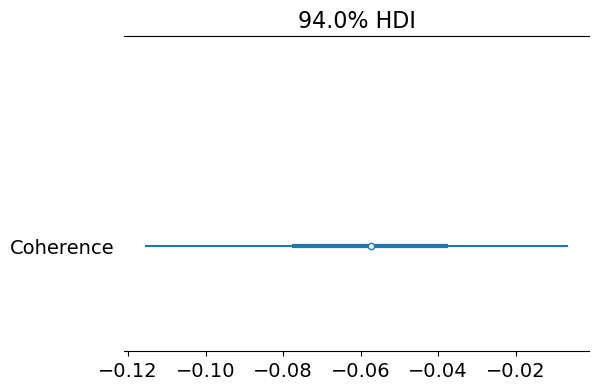

In [48]:
az.plot_forest(
    complete_pooled_trace,
    var_names=["Coherence"],
    filter_vars="like",
    combined = True)

模型2：部分池化模型（变化截距）

In [80]:
var_inter_trace = var_inter_model.fit(idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_RTs_sigma, Intercept, Coherence, 1|subj_id_sigma, 1|subj_id_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.
There were 196 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [50]:
var_inter_para = az.summary(var_inter_trace)
var_inter_para 

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,7.065,0.309,6.500,7.688,0.023,0.016,189.0,272.0,1.03
Coherence,-0.063,0.023,-0.108,-0.021,0.000,0.000,2430.0,2058.0,1.01
log_RTs_sigma,0.559,0.008,0.544,0.574,0.000,0.000,1448.0,2011.0,1.00
1|subj_id_sigma,0.700,0.320,0.251,1.406,0.059,0.047,49.0,24.0,1.06
1|subj_id[66670],-0.139,0.310,-0.735,0.460,0.023,0.016,193.0,309.0,1.03
1|subj_id[80941],0.137,0.310,-0.477,0.719,0.023,0.018,188.0,301.0,1.03
1|subj_id[81844],-0.641,0.309,-1.269,-0.076,0.023,0.016,189.0,277.0,1.03
1|subj_id[83824],0.085,0.310,-0.502,0.673,0.023,0.017,186.0,369.0,1.03
1|subj_id[83956],0.689,0.311,0.098,1.282,0.023,0.018,189.0,312.0,1.03


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

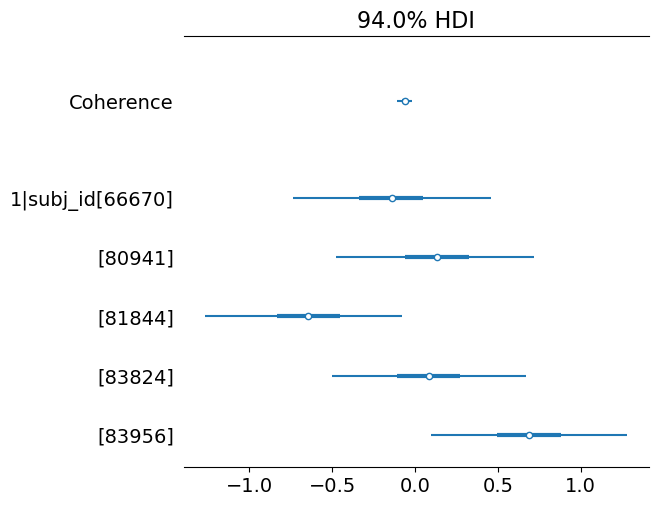

In [51]:
az.plot_forest(var_inter_trace,
           var_names=["~Intercept", "~sigma"],
           filter_vars="like",
           combined = True)

**模型3**：部分池化模型（变化截距和斜率）

In [81]:
var_both_trace = var_both_model.fit(idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_RTs_sigma, Intercept, Coherence, 1|subj_id_sigma, 1|subj_id_offset, Coherence|subj_id_sigma, Coherence|subj_id_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 76 seconds.
There were 308 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [53]:
var_both_para = az.summary(var_both_trace)
var_both_para

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,7.080,0.332,6.512,7.798,0.012,0.009,716.0,849.0,1.00
Coherence,-0.097,0.124,-0.308,0.119,0.005,0.003,966.0,1070.0,1.01
log_RTs_sigma,0.556,0.008,0.541,0.571,0.000,0.000,1333.0,1339.0,1.00
1|subj_id_sigma,0.785,0.377,0.313,1.555,0.028,0.024,323.0,146.0,1.01
Coherence|subj_id_sigma,0.215,0.151,0.048,0.449,0.006,0.005,666.0,980.0,1.01
1|subj_id[66670],-0.201,0.334,-0.888,0.395,0.013,0.009,713.0,855.0,1.00
1|subj_id[80941],0.168,0.333,-0.489,0.785,0.013,0.009,714.0,928.0,1.00
1|subj_id[81844],-0.692,0.333,-1.404,-0.115,0.013,0.009,718.0,899.0,1.00
1|subj_id[83824],0.070,0.333,-0.610,0.670,0.013,0.009,703.0,715.0,1.00
1|subj_id[83956],0.786,0.334,0.114,1.388,0.012,0.009,731.0,998.0,1.00


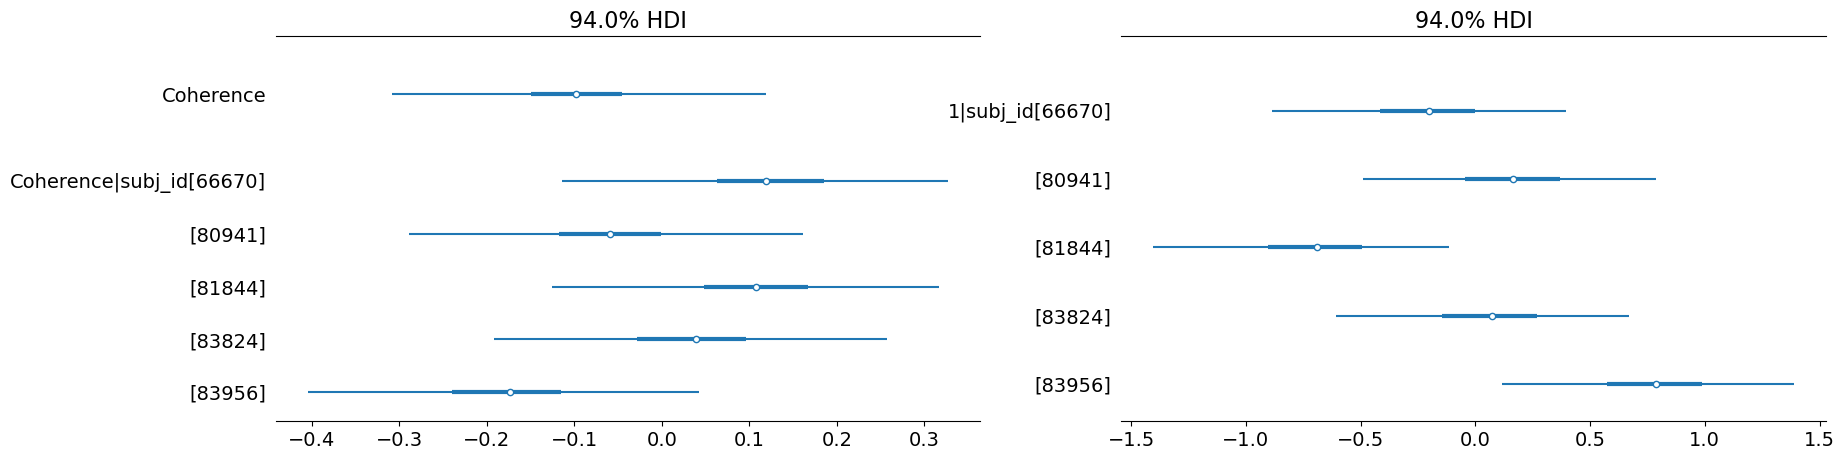

In [63]:
# 设置绘图坐标
figs, (ax1, ax2) = plt.subplots(1,2, figsize = (20,5))
# 绘制变化的截距
az.plot_forest(var_both_trace,
           var_names=["Coherence\\|subj_id", "~sigma", "~1|", "~Intercept"],
           filter_vars="like",
           combined = True,
           ax=ax1)
# 绘制变化的斜率
az.plot_forest(var_both_trace,
           var_names=["1|subj_id", "~sigma", "~Coherence", "~Intercept"],
           filter_vars="like",
           combined = True,
           ax=ax2)
plt.show()

### 模型比较

##### 模型评估指标

在分析模型的预测能力时，有绝对指标和相对指标，绝对指标用于衡量模型预测值与真实值之间的差异，相对指标用于比较不同模型的预测能力，通常用于不同方法或模型之间的性能对比。

##### 绝对指标：

* 在之前的课程中介绍过对后验预测结果进行评估的两种方法  

* 一是**MAE**，即后验预测值与真实值之间预测误差的中位数，二是**within_95**，即真实值是否落在95%后验预测区间内  

* 在这里调用之前写过的计算两种指标的方法，评估两种分层模型的后验预测结果


##### 相对指标

在实际操作中，我们通过 `ArViz` 的函数`az.loo`计算 $ELPD_{LOO-CV}$。  

PSIS-LOO-CV 有两大优势：  
1. 计算速度快，且结果稳健  
2. 提供了丰富的模型诊断指标  

In [90]:
complete_pooled_model.predict(complete_pooled_trace, kind="pps")
var_inter_model.predict(var_inter_trace, kind="pps")
var_both_model.predict(var_both_trace, kind="pps")

In [92]:
complete_pooled_trace

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [93]:
# 定义计算 MAE 函数
from statistics import median
def MAE(trace):
    # 计算每个X取值下对应的后验预测模型的均值
    pre_x = trace.posterior_predictive["log_RTs"].stack(sample=("chain", "draw"))
    pre_y_mean = pre_x.mean(axis=1).values

    # 提取观测值Y，提取对应Y值下的后验预测模型的均值
    MAE = pd.DataFrame({
        "ppc_mean": pre_y_mean,
        "original": trace.observed_data.log_RTs.values
    })

    # 计算预测误差
    MAE["pre_error"] = abs(MAE["original"] -\
                            MAE["ppc_mean"])

    # 最后，计算预测误差的中位数
    MAE = median(MAE.pre_error)
    return MAE

In [102]:
# 定义
def counter_outlier(model_trace, hdi_prob=0.95):
    # 将az.summary生成的结果存到hdi_multi这个变量中，该变量为数据框
    hdi = az.summary(model_trace.posterior_predictive, kind="stats", hdi_prob=hdi_prob)
    lower = hdi.iloc[:,2].values
    upper = hdi.iloc[:,3].values

    # 将原数据中的自我控制分数合并，便于后续进行判断
    y_obs = model_trace.observed_data["log_RTs"].values

    # 判断原数据中的压力分数是否在后验预测的95%可信区间内，并计数
    hdi["verify"] = (y_obs <= lower) | (y_obs >= upper)
    hdi["y_obs"] = y_obs
    hdi_num = sum(hdi["verify"])

    return hdi_num

In [103]:
# 将每个模型的PPC储存为列表
ppc_samples_list = [complete_pooled_trace, var_inter_trace, var_both_trace]
model_names = ["完全池化", "变化截距", "变化截距、斜率"]

# 建立一个空列表来存储结果
results_list = []

# 遍历模型并计算MAE和超出95%hdi的值
for model_name, ppc_samples in zip(model_names, ppc_samples_list):
    outliers = counter_outlier(ppc_samples)
    MAEs = MAE(ppc_samples)
    results_list.append({'Model': model_name, 'MAE':MAEs, 'Outliers': outliers})

# 从结果列表创建一个DataFrame
results_df = pd.DataFrame(results_list)

results_df

,Model,MAE,Outliers
0,完全池化,0.517794,125
1,变化截距,0.316176,158
2,变化截距、斜率,0.307307,154


In [104]:
comparison_list = {
    "model1(complete pooling)":complete_pooled_trace,
    "model2(hierarchical intercept)":var_inter_trace,
    "model3(hierarchy both)":var_both_trace,
}
az.compare(comparison_list)

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model3(hierarchy both),0,-1941.431752,13.064896,0.000000,0.884853,37.106601,0.000000,False,log
model2(hierarchical intercept),1,-1950.120395,8.071729,8.688643,0.115147,36.892828,4.741897,False,log
model1(complete pooling),2,-2502.072721,3.013059,560.640969,0.000000,34.205582,27.353555,False,log


通过 `arviz.compare` 方法来对比多个模型的 elpd。从下面结果可见： 
 
- 模型3的 elpd_loo 最大，表明它对**样本外数据**的预测性能最好。  
- 而模型1的 elpd_loo 最小，表明它的预测性能最差。  

因此，根据模型评估的结果，可以发现模型3（变化截距和变化斜率）的结果在3个模型中是最好的。

### 贝叶斯统计推断

模型比较发现，模型3（变化截距和变化斜率）的结果在3个模型中是最好的。最后，将使用 HDI + ROPE 和贝叶斯因子（Bayes Factor，BF）来进行统计推断。

#### HDI + ROPE 的统计推断

* 反应时差异的后验分布平均值为 -281 ms，然而，这一数值并不足以断定实验条件对反应时间有显著的减少作用。
* 95% HDI 范围为 [-608 ms, 48 ms]，表明后验分布中95%的概率下的反应时差异位于此区间。由于95% HDI 包含了0，并且分布主要集中在负值方向，但这一趋势并不足以证明存在显著的效应。
* ROPE 设定了一个 [-30 ms, 30 ms] 的实用等效区间，用以判断反应时差异是否具有实际意义。ROPE 内的概率仅为1.6%，尽管这表明在大多数情况下反应时差异超出了可忽略的范围，但这一差异仍不足以被视为显著。


#### 贝叶斯因子（Bayes Factor，BF）

反应时的差异（beta_1）在统计上和实际意义上均不显著。
* 数据强烈支持 无效假设（beta_1 = 0），即反应时差异可能不存在或非常微弱。
* 贝叶斯因子 BF_10 = 0.01 提供了明确的证据，表明 beta_1 不显著。
* 从后验分布来看，数据更新后 beta_1 的可能值仍然集中在 0 附近，进一步支持无效假设。


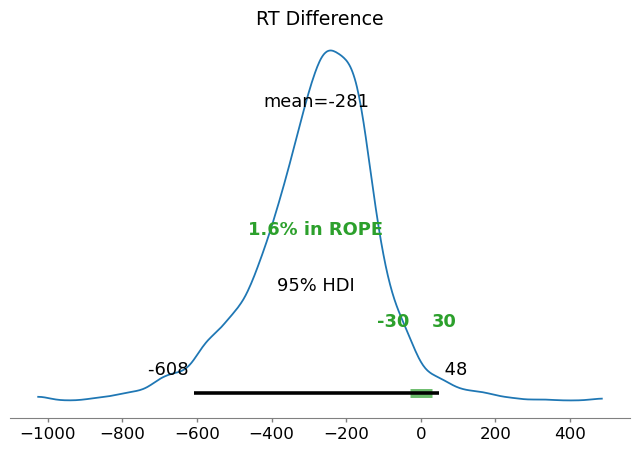

In [106]:
# 从贝叶斯模型的后验分布中提取参数
def inv_log(mu, sigma):
    return np.exp(mu + (sigma ** 2) / 2)

Intercept_mu = var_both_trace.posterior.stack(sample=("chain", "draw")).get("Intercept")
Coherence_mu = var_both_trace.posterior.stack(sample=("chain", "draw")).get("Coherence")
Intercept_sigma = var_both_trace.posterior.stack(sample=("chain", "draw")).get("1|subj_id_sigma")
Coherence_sigma = var_both_trace.posterior.stack(sample=("chain", "draw")).get("Coherence|subj_id_sigma")

# 计算两个条件下的反应时间
rt_coh_5 = inv_log(Intercept_mu, Intercept_sigma)
rt_coh_10 = inv_log(Intercept_mu+Coherence_mu, Coherence_sigma)
rt_coh_5 = rt_coh_5[(rt_coh_5 >= 300) & (rt_coh_5 <= 1500)]
rt_coh_10 = rt_coh_10[(rt_coh_10 >= 300) & (rt_coh_10 <= 1500)]

rt_diff = rt_coh_10 - rt_coh_5
rt_diff = rt_diff.values

# 定义 ROPE 区间，根据研究的需要指定实际等效范围
rope_interval = [-30, 30]

# 绘制后验分布，显示 HDI 和 ROPE
az.plot_posterior(
    {"RT Difference":rt_diff},
    hdi_prob=0.95,
    rope=rope_interval,
    figsize=(8, 5),
    textsize=12
)

plt.show()

Sampling: [1|subj_id_offset, 1|subj_id_sigma, Coherence, Coherence|subj_id_offset, Coherence|subj_id_sigma, Intercept, log_RTs, log_RTs_sigma]


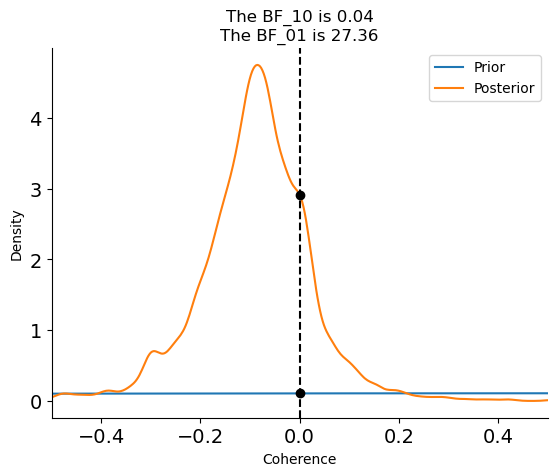

In [108]:
# 进行贝叶斯因子计算，需要采样先验分布
var_both_trace.extend(var_both_model.prior_predictive(random_seed=84735) )

# 绘制贝叶斯因子图
az.plot_bf(var_both_trace, var_name="Coherence", ref_val=0)

# 设置 x 轴的范围
plt.xlim(-0.5, 0.5) 

# 去除上框线和右框线
sns.despine()

### 结论


通过模型建立和模型比较，相比于模型1和模型2，模型3（变化截距和变化斜率）的效果最好。因此，在随机点运动范式中，反应时间显著受到随机点运动方向一致性比例的影响。

具体而言，模型3考虑了变化截距和变化斜率，这意味着它不仅捕捉到了不同条件下反应时间的平均差异，还考虑了这些差异随条件变化的趋势。相比之下，模型1和模型2未能充分捕捉到这些复杂的变化模式，因而在预测精度和模型拟合度上表现不如模型3。


### 大作业注意事项

在完成大作业时，请注意以下几点要求：

1. **文档**：
   - 请按照APA7论文格式撰写文档，确保内容完整、格式规范。
   - 文档应包括研究背景、方法、结果和讨论等部分，详细描述研究过程和发现。

2. **和鲸Notebook演示（或PPT）**：
   - 使用和鲸Notebook或PPT进行演示，清晰展示研究的各个步骤和结果。
   - 演示内容应包括数据处理、模型构建、结果分析和结论等部分。

3. **代码**：
   - 提交完整的代码，确保代码可以运行并生成预期结果。
   - 代码应包括数据导入、预处理、模型构建、拟合和结果分析等部分。
   - 请在代码中添加必要的注释。


💡互评环节：

在2025年1月3号的最后一次课时，各小组将进行大作业汇报。每组可以对其他汇报组进行评分，评分标准包括文档规范性、演示效果和代码运行情况等。

